In [72]:
#!pip3 install torch torchvision torchaudio

In [73]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [74]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score


In [75]:
class FlowerDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['daisy', 'roses', 'sunflowers', 'tulips']
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.images = []
        self.labels = []
        # Load image paths and corresponding labels (AI Suggestion was used in next 4 lines )
        for cls_name in self.classes:
            cls_dir = os.path.join(root_dir, cls_name)
            if os.path.isdir(cls_dir):
                for file_name in os.listdir(cls_dir):
                    if file_name.endswith(('.jpg', '.jpeg', '.png')):
                        self.images.append(os.path.join(cls_dir, file_name))
                        self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = self.images[index]
        image = Image.open(img_path).convert('RGB')  # Ensure RGB format
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformation (AI was used to solve overfitting issue)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = FlowerDataset(root_dir='./data/train', transform=transform)
test_dataset = FlowerDataset(root_dir='./data/test', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

classes = train_dataset.classes  

# Example Usage
print(f"Classes: {classes}")


Classes: ['daisy', 'roses', 'sunflowers', 'tulips']


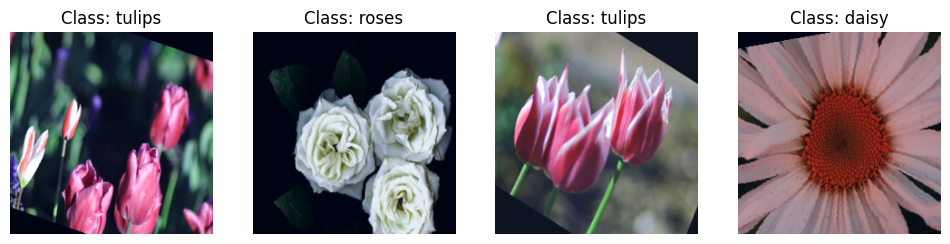

In [76]:
def show_first_images(dataloader, classes, num_images=4):
    data_iter = iter(dataloader)  # Get an iterator from the DataLoader
    images, labels = next(data_iter)  # Get the first batch
    
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        img = images[i].permute(1, 2, 0).numpy()  # Convert image to HWC format for display  ( AI USED )
        img = (img * 0.229 + 0.485).clip(0, 1)  # De-normalize the image (using ImageNet mean/std) ( AI USED )
        plt.imshow(img)
        plt.title(f"Class: {classes[labels[i]]}")
        plt.axis('off')
    plt.show()
show_first_images(train_loader, classes)

In [77]:
class Classify_Flower(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classify_Flower, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )
        
    def forward(self, x):
        return self.model(x)

# Example usage
input_size = 224 * 224 * 3  # Assuming image size is 224x224x3
num_classes = len(classes)  # Replace with the actual number of classes
model = Classify_Flower(input_size, num_classes)
print(model)


Classify_Flower(
  (model): Sequential(
    (0): Linear(in_features=150528, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
    (10): Linear(in_features=16, out_features=4, bias=True)
  )
)


Used Device: cpu
Epoch [1/20], Training Loss: 1.2155, Test Loss: 1.1723
Training Accuracy: 44.66%
Epoch [2/20], Training Loss: 1.1340, Test Loss: 1.0976
Training Accuracy: 50.06%
Epoch [3/20], Training Loss: 1.0580, Test Loss: 1.1057
Training Accuracy: 54.09%
Epoch [4/20], Training Loss: 1.0186, Test Loss: 1.0942
Training Accuracy: 56.59%
Epoch [5/20], Training Loss: 1.0228, Test Loss: 1.1064
Training Accuracy: 55.80%
Epoch [6/20], Training Loss: 1.0052, Test Loss: 1.1159
Training Accuracy: 57.27%
Epoch [7/20], Training Loss: 0.9713, Test Loss: 1.0149
Training Accuracy: 59.15%
Epoch [8/20], Training Loss: 0.9600, Test Loss: 1.0030
Training Accuracy: 59.20%
Epoch [9/20], Training Loss: 0.9415, Test Loss: 1.0108
Training Accuracy: 59.49%
Epoch [10/20], Training Loss: 0.9349, Test Loss: 1.0483
Training Accuracy: 60.23%
Epoch [11/20], Training Loss: 0.9128, Test Loss: 1.0597
Training Accuracy: 62.56%
Epoch [12/20], Training Loss: 0.9255, Test Loss: 1.0357
Training Accuracy: 60.00%
Epoch [1

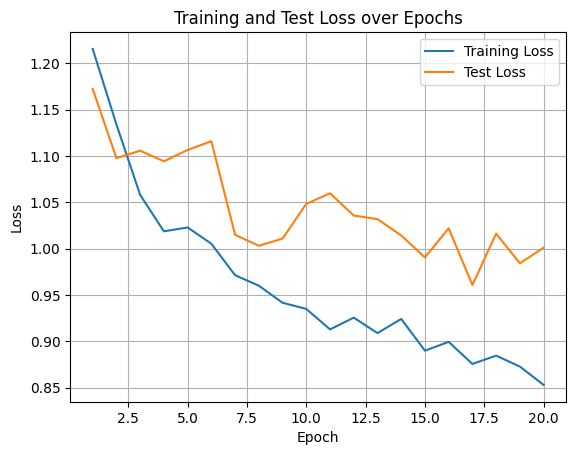

In [78]:
def train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs):
    # Move model to the specified device
    model.to(device)
    
    # Initialize lists to store loss history
    train_loss_history = []
    test_loss_history = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()  # Set model to training mode
        epoch_train_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Accumulate epoch loss (AI suggestion used)
            epoch_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate and store average training loss and accuracy for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        train_loss_history.append(avg_train_loss)
        
        # Validation phase (calculate test loss)
        model.eval()  # Set model to evaluation mode
        epoch_test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.view(inputs.size(0), -1)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_test_loss += loss.item()
        
        avg_test_loss = epoch_test_loss / len(test_loader)
        test_loss_history.append(avg_test_loss)
        
        # Print epoch progress
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
        print(f'Training Accuracy: {epoch_accuracy:.2f}%')
    
    # Plot the training and test loss over epochs
    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), test_loss_history, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_loss_history, test_loss_history

# Example Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Used Device:", device)

model = Classify_Flower(input_size=input_size, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20
train_loss_history, test_loss_history = train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs)


In [79]:
def evaluate_model(model, test_loader, device):

    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    model.to(device)  # Move model to the specified device

    with torch.no_grad():  # Disable gradient computation for evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device
            images = images.view(images.size(0), -1)  # Flatten inputs if required
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f'Test Accuracy: {accuracy:.2f}')

    print(f'Test F1 Score: {f1:.2f}')
    print('\nConfusion Matrix:')
    print(conf_matrix)

    return {
        "accuracy": accuracy,
        "f1_score": f1,
        "confusion_matrix": conf_matrix
    }

# Example usage
# Assuming test_loader is defined and the model is trained
metrics = evaluate_model(model, test_loader, device)


Test Accuracy: 0.60
Test F1 Score: 0.59

Confusion Matrix:
[[78 10  8 14]
 [26 49 13 22]
 [10  7 78 15]
 [17 22 14 57]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.2565577].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9776908].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..2.2216995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


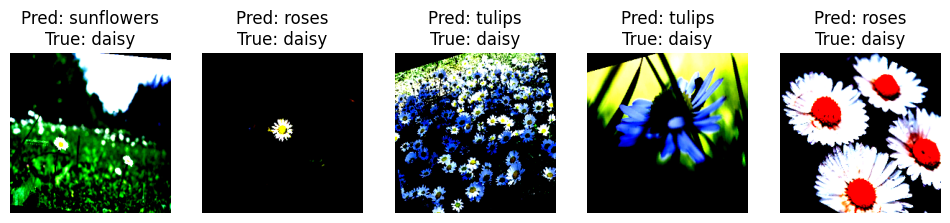

In [80]:
def show_misclassified_images(model, test_loader, classes, device):
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    correct_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images.view(images.size(0), -1))
            _, preds = torch.max(outputs, 1)
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified_images.append(images[i].cpu())
                    misclassified_labels.append(classes[preds[i]])
                    correct_labels.append(classes[labels[i]])
    plt.figure(figsize=(12, 8))
    for i in range(min(len(misclassified_images), 5)):  # Show up to 5 misclassified images(slightly help with ai as i faced an error in plotting)
        plt.subplot(1, 5, i + 1)
        plt.imshow(misclassified_images[i].permute(1, 2, 0))
        plt.title(f"Pred: {misclassified_labels[i]}\nTrue: {correct_labels[i]}")
        plt.axis('off')
    plt.show()
show_misclassified_images(model, test_loader, classes, device)